In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import extract_file_name, all_paths_exist, read_preprocessed_driving_csv, preprocess


KeyboardInterrupt



In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
raw_folders = ['good 1', 'track 1 normal', 'track 1 reverse', 'track 2 normal']

In [ ]:
def read_raw_driving_csv(folder: str):
    csv_path = '.\\data\\raw\\{0}\\driving_log.csv'.format(folder)

    with open(csv_path, 'r') as f:
        return pd.read_csv(
            csv_path,
            header=None,
            names=['center', 'left', 'right', 'steering_angle'],
            usecols=[0, 1, 2, 3],
            converters={
                'center': lambda x: extract_file_name(x),
                'left': lambda x: extract_file_name(x),
                'right': lambda x: extract_file_name(x)
            }
        )


In [ ]:
def remove_non_triple_images(raw_folders):
    for folder in raw_folders:
        remove_indexes = []
        print('-- Checking {0}'.format(folder))

        df = read_raw_driving_csv(folder)
        print('DF Before: ', len(df))

        for index, row in df.iterrows():
            center = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['center'])
            left = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['left'])
            right = '.\\data\\raw\\{0}\\IMG\\{1}'.format(folder, row['right'])

            # if an image does not exist, remove all images from the same row
            if not all_paths_exist([center, left, right]):
                for path in [center, left, right]:
                    if os.path.exists(path):
                        os.remove(path)

                remove_indexes.append(index)

        df.drop(index=df.index[remove_indexes], inplace=True)
        print('DF After : ', len(df))

        csv_path = '.\\data\\raw\\{0}\\driving_log.csv'.format(folder)
        df.to_csv(csv_path, index=False, header=False)

In [ ]:
remove_non_triple_images(raw_folders)

# Load and Visualize Dataset

In [ ]:
full_set = pd.DataFrame()

for folder in raw_folders:
    df = read_raw_driving_csv(folder)
    df['folder'] = folder
    full_set = pd.concat([full_set, df], ignore_index=True)

In [ ]:
full_set.dtypes

In [ ]:
full_set.head()

In [ ]:
full_set.iloc[1]

In [130]:
full_set.iloc[1]['folder']

'good 1'

In [131]:
full_set['steering_angle'][1]

-0.15

# Balance the Dataset

In [132]:
num_bins = 21
samples_per_bin = 920

In [133]:
def show_steering_angles(full_set, hist, bins, samples_per_bin):
    center = (bins[:-1] + bins[1:]) * 0.5
    plt.bar(center, hist, width=0.05)
    plt.plot(
        (np.min(full_set['steering_angle']), np.max(full_set['steering_angle'])),
        (samples_per_bin, samples_per_bin)
    )

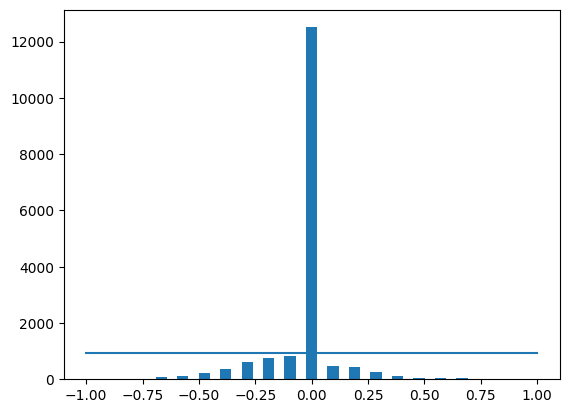

In [134]:
hist, bins = np.histogram(full_set['steering_angle'], num_bins)
show_steering_angles(full_set, hist, bins, samples_per_bin)

In [135]:
print('total data:', len(full_set))
remove_list = []

for j in range(num_bins):
  list_ = []
  for i in range(len(full_set['steering_angle'])):
    if bins[j] <= full_set['steering_angle'][i] <= bins[j + 1]:
      list_.append(i)

  random.shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
full_set.drop(full_set.index[remove_list], inplace=True)
print('remaining:', len(full_set))

total data: 17007
removed: 11586
remaining: 5421


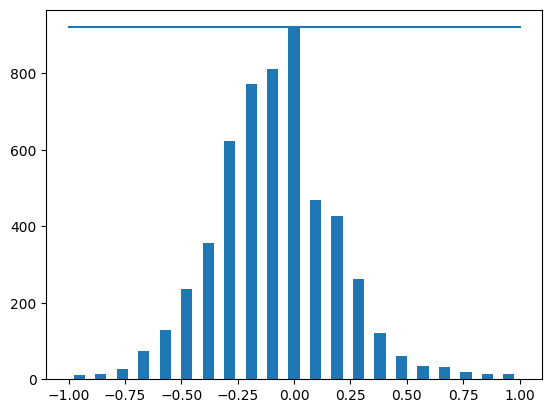

In [136]:
hist, bins = np.histogram(full_set['steering_angle'], num_bins)
show_steering_angles(full_set, hist, bins, samples_per_bin)

# Split the CSV

In [137]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(full_set, train_size=0.9, shuffle=True)

In [138]:
len(full_set), len(X_train), len(X_test)

(5421, 4878, 543)

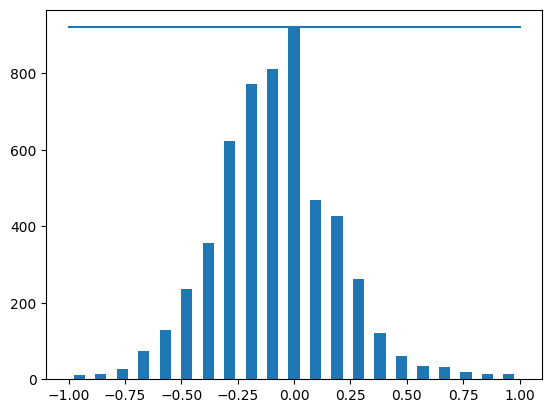

In [139]:
show_steering_angles(X_train, hist, bins, samples_per_bin)

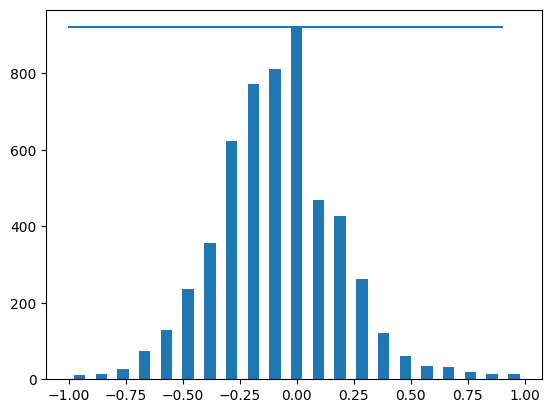

In [140]:
show_steering_angles(X_test, hist, bins, samples_per_bin)

In [141]:
X_train.head()

,center,left,right,steering_angle,folder
13719,center_2023_04_28_21_08_44_295.jpg,left_2023_04_28_21_08_44_295.jpg,right_2023_04_28_21_08_44_295.jpg,0.055932,track 1 reverse
15093,center_2023_04_28_21_11_07_631.jpg,left_2023_04_28_21_11_07_631.jpg,right_2023_04_28_21_11_07_631.jpg,0.111866,track 1 reverse
14763,center_2023_04_28_21_10_34_157.jpg,left_2023_04_28_21_10_34_157.jpg,right_2023_04_28_21_10_34_157.jpg,0.475576,track 1 reverse
3729,center_2019_04_02_19_30_02_017.jpg,left_2019_04_02_19_30_02_017.jpg,right_2019_04_02_19_30_02_017.jpg,-0.100000,good 1
16733,center_2023_04_28_21_25_41_473.jpg,left_2023_04_28_21_25_41_473.jpg,right_2023_04_28_21_25_41_473.jpg,-0.327467,track 2 normal


# Preprocess Images

In [142]:
import os, shutil

def clear_folder(folder):
    for files in os.listdir(folder):
        path = os.path.join(folder, files)
        try:
            shutil.rmtree(path)
        except OSError:
            os.remove(path)


In [143]:
count = 0
for files in os.listdir('.\\data\\preprocessed\\train'):
    count += 1

count

14850

In [144]:
from torchvision.io import read_image
from PIL import Image

PREPROCESSED_FOLDER = '.\\data\\preprocessed\\'

def preprocess_and_store_images(df, stage='train'):
    clear_folder(PREPROCESSED_FOLDER + stage)
    # os.mkdir(PREPROCESSED_FOLDER + stage)

    for index, row in df.iterrows():
        folder = row['folder']

        for image_name in ['center', 'left', 'right']:
            image_name = row[image_name]
            raw_path = '.\\data\\raw\\' + folder + '\\IMG\\' + image_name

            if not os.path.exists(raw_path):
                continue

            image = read_image(raw_path)
            # print('Original Shape : ', image.shape)
            image = preprocess(image)
            # print('New Shape : ', image.shape)
            # print(image[0, 0, :10])

            path = '{}\\{}\\{}'.format(PREPROCESSED_FOLDER, stage, image_name)
            Image.fromarray(image.numpy().transpose(1, 2, 0)).save(path)

In [145]:
preprocess_and_store_images(X_train, 'train')
preprocess_and_store_images(X_test, 'test')

# Check is All Images Exist

In [146]:
def check_all_images_exist(df):
    count = 0

    for index, row in df.iterrows():
        folder = row['folder']

        for image_name in ['center', 'left', 'right']:
            image_name = row[image_name]
            raw_path = '.\\data\\raw\\' + folder + '\\IMG\\' + image_name

            if not os.path.exists(raw_path):
                count += 1
                print(raw_path)

    return count

In [147]:
count = check_all_images_exist(X_train)
print(count)

count = check_all_images_exist(X_test)
print(count)

0
0


# Save CSV

In [148]:
X_train.to_csv(
    '.\\data\\preprocessed\\driving_train_log.csv',
    index=False,
    columns=['center', 'left', 'right', 'steering_angle']
)

X_test.to_csv(
    '.\\data\\preprocessed\\driving_test_log.csv',
    index=False,
    columns=['center', 'left', 'right', 'steering_angle']
)